# Basic pipeline

## Introduction

We'll get started importing `scycle` itself, and from there using single-cell RNA-seq from an Ewing Sarcoma cell line named CHLA9 \[ref for original work\]. `scycle` accepts `AnnData` objects as imputs. In this case, we internally download and the data from a `loom` file, which will also allow us to showcase the integration of the pipeline with `scvelo` and RNA velocity.

In [1]:
import scycle as cc

In [2]:
chla9 = cc.data.get_data('CHLA9')

-- Loading data from cache...


In [3]:
chla9

AnnData object with n_obs × n_vars = 5061 × 60662
    obs: 'TotalUMIs'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID'
    layers: 'matrix', 'spliced', 'unspliced'

## Pre-processing

Though samples can be pre-processed by other pipelines before using `scycle`, we implemented our own pre-processing pipeline. In the `filter_cells` stage, only quality control attempting to deal with low-quality cells is done. We also have integration with `DoubletDetection` to perform doublet removal inside of this step.

In [4]:
cc.pp.filter_cells(chla9)

3851 cells pass the count filter
4599  cells pass the mt filter
Cells selected 3813


Then, the standard preprocessing recipe for scycle is called `prep_pooling`. This recipe includes an unconventional step that we find improves in the annotation of cell cycling: pooling (i.e. *smoothing*) cells using their nearest neighbors in a reference space. Otherwise, this step also performs library size normalization, log2-transformation and selects the most highly varying genes in the dataset.

In [5]:
cc.pp.prep_pooling(chla9)

Preparing embedding...
Embedding for pooling...
Pooling 3813 cells...
Scoring cell cycle...


An optional step in the pipeline that may improve downstream analysis, particularly finding the moment of cell division in the trajectory, is to normalize counts with reference to the mean total counts by partition. This is performed in a single-step in scycle in the `pp` module:

In [6]:
cc.pp.normalize_by_partition(chla9, n_ref_parts = 10)

Preprocessing reference with default values...
-- Running `tl.self_consistent_trajectory` with n_ref_parts...
-- Trajectory not not computed: computing it with default parameters.
Re-normalizing counts by partition...


## Dimensionality reduction

`tl.dimensionality_reduction` reduces the dimensionality of the data, by default, using Independent Component Analysis (ICA), as implemented in StabilizedICA. From the stable ICs, scycle then identifies the independent components related to cell cycle. Four possible dimensions are investigated: the two main known signatures of cell cycle, comprised of  G1/S and G2/M, as well as 2 additional processes that are often but not always represented in the data. The Histones signature, which is comprised of histone genes, increases through S-phase and is stable through G2. The G2/M inhibitory (or G2-M-) signature related to a 'delayed' G2/M signal, which is still high at the start of G1 and whose transcripts start degrading later than transcripts forming the G2/M signature. This selection is performed by `tl.dimensionality_reduction` if `method = 'ica'` and `find_cc_comps = True`, which is default. It can be performed as a separate step invoking `tl.find_cc_components`.

In this example, we'll showcase an alternative dimensionality reduction methodology (`method = 'self_consistent_CC`), which starts from the approximation that uses the ICA followed by selection of cell-cycle components, and then uses the initial approximation of the cell cycle space to find genes related to cell cycle. These genes will be used as the reference for a principal component analysis, which will have a higher dimensionality space (`n_comps`-D) than the 3-4 D space found by the ICA. This has some benefits when calculating cell cycle trajectory later.

In [7]:
cc.tl.dimensionality_reduction(chla9, method = 'self_consistent_CC')

Dimensionality reduction using self consistent CC genes..
Initial estimation using ICA...
Cell cycle genes initially found: 273
Top ones: ['H4C3', 'TOP2A', 'HMGB2', 'KPNA2', 'CCNB1', 'CDC20', 'UBE2C', 'H1-5', 'CKS2', 'H1-3', 'PLK1', 'DLGAP5', 'AURKA', 'KIF2C', 'NUF2', 'AURKB', 'TPX2', 'NUSAP1', 'CENPE', 'HMMR', 'TACC3', 'NCAPG', 'CENPA', 'AC027237.1', 'PIF1', 'CDCA3', 'KIFC1', 'KIF20A']


Iteration 1 ==================
Jaccard coeff: 0.9350180505415162 Old: 273 New: 263 



Iteration 2 ==================
Jaccard coeff: 0.9886363636363636 Old: 263 New: 262 

Reducing dimensionality using self-consistent CC genes...


We can inspect our scycle results visually using the plotting module, but also by looking at the AnnData itself.

In [8]:
chla9

AnnData object with n_obs × n_vars = 3813 × 10000
    obs: 'TotalUMIs', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'G1-S', 'G2-M', 'Histones', 'total_counts_raw'
    var: 'Accession', 'AccessionVersion', 'Aliases', 'CcdsID', 'Chromosome', 'ChromosomeEnd', 'ChromosomeStart', 'CosmicID', 'DnaBindingDomain', 'FullName', 'GeneType', 'HgncID', 'IsTF', 'Location', 'LocationSortable', 'LocusGroup', 'LocusType', 'MgdID', 'MirBaseID', 'OmimID', 'PubmedID', 'RefseqID', 'RgdID', 'UcscID', 'UniprotID', 'VegaID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scycle', 'log1p', 'dimRed', 'P_dimRed'
    obsm: 'X_dimRed', 'X_pca_scycle'
    layers: 'matrix', 'spliced', 'unspliced', 'unnorm'

The previous steps have added multiple layers and variables to the AnnData. Here, we're going to focus on the `obsm`, which are dimensionality reductions. Feel free to take a look at other additions (e.g. `chla9.uns['scycle']` will have the parameters for functions that have run)

In [9]:
chla9.obsm['X_dimRed'].shape, chla9.obsm['X_pca_scycle'].shape

((3813, 30), (3813, 3))

In this case, `X_dimRed` is a 30-D PCA in the self-consistent cell-cycle genes, while `X_pca_scycle` is also a PCA with 3 PCs, which is used by the plotting module. `scycle` provides 2-D and 3-D visualizations using `cc.pl.cell_cycle_pca` and `cc.pl.cell_cycle_pca3D`

## Trajectory and cell division

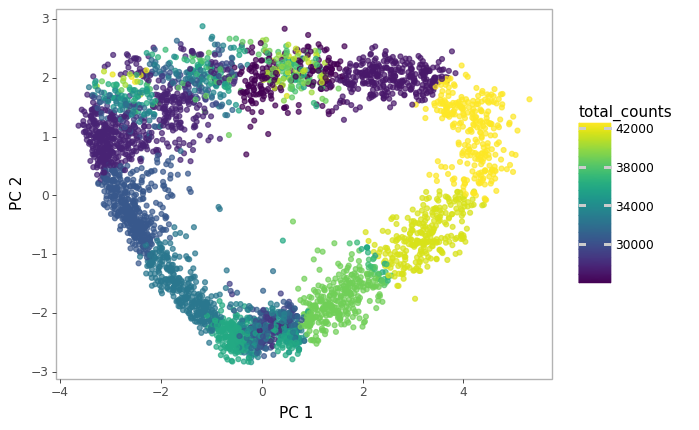

<ggplot: (8771737847206)>

In [10]:
cc.pl.cell_cycle_pca(chla9)

From this image, we can clearly see the trajectory, but also the effect of the partition counts normalization that segments the counts. We can get the trajectory from the principal elastic circle estimation using `elpigraph`, implemented in `scycle` as `tl.trajectory`:

In [11]:
cc.tl.trajectory(chla9)

Now we can look at the trajectory. We'll also plot it using the unormalized total_counts (`total_counts_raw`). We can still see a clear gradual increase in total counts, and the sudden drop-off at the moment of cell division (around node 6-7). Of note, when performing the partition normalization and using the self-consistent CC genes for dimensionality reduction, we often can find a "dimple" at the moment of cell division.

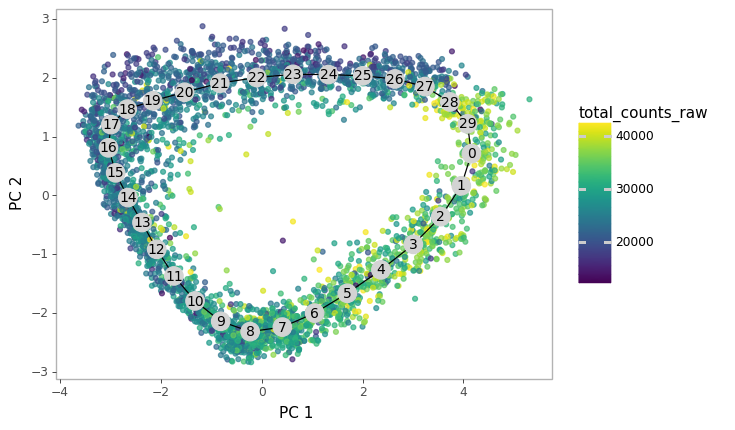

<ggplot: (8771554129372)>

In [12]:
cc.pl.cell_cycle_pca(chla9, trajectory = True, col_var = 'total_counts_raw')

In [13]:
cc.pl.cell_cycle_pca3d(chla9, col_var = 'total_counts_raw', alpha = 0.5, trajectory = True)

`tl.cell_division` will attempt to find the moment of cell division using `total_counts` (in this case, the normalized counts). It will set the direction of the trajectory as the direction of increasing counts, and the moment of cell division as the largest dip in total counts from the previous node. In this way, we can "break" the circle into a linear trajectory, and calculate pseudotime.

Suggested moment of cell division: [27 28]
Direction of cell cycle: -1
Remapping edges using [27 28] ...


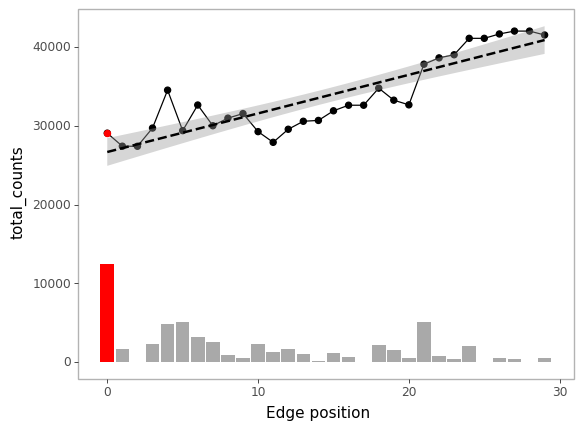

<ggplot: (8771554122445)>

In [14]:
cc.tl.cell_division(chla9)
cc.pl.cell_division(chla9)

## Pseudotime

Calculating pseudotimes for each cell...


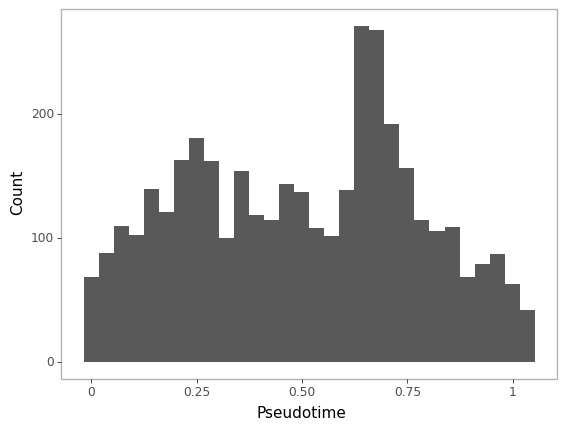

<ggplot: (8771580688707)>

In [15]:
cc.tl.pseudotime(chla9)
cc.pl.pseudotime_histogram(chla9)

We can see the distribution of cell over pseudotime, but now we can in fact plot many variables vs pseudotime in our data. For example, we can look at un-normalized counts:

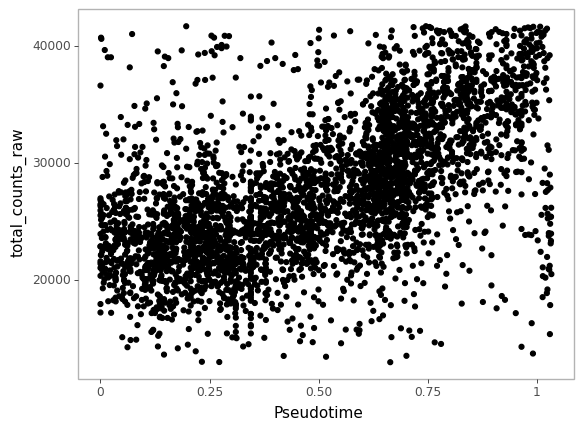

<ggplot: (8771579965082)>

In [16]:
cc.pl.pseudotime_scatter(chla9, 'total_counts_raw')

Or the expression of some selected genes:

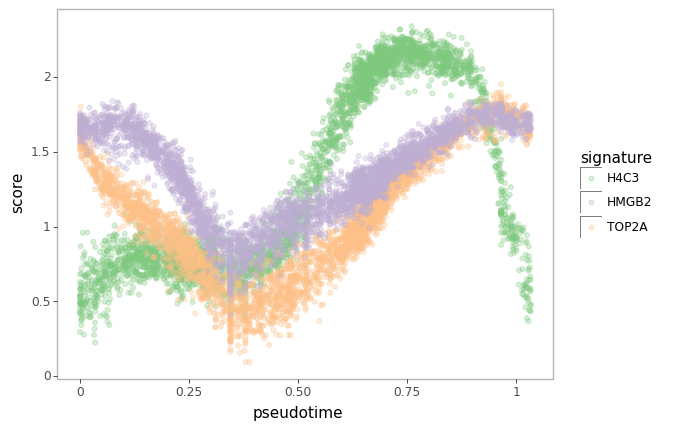

<ggplot: (8771579926095)>

In [40]:
from plotnine import scale_color_brewer
(cc.pl.pseudotime_scatter(chla9, ['H4C3', 'TOP2A', 'HMGB2'], alpha=0.3) +
    scale_color_brewer(type = 'qual', palette = 'Accent'))

And, obviously, at the dynamics of cell cycle signatures over pseudotime. We could use `pl.pseudotime_scatter` again, but this is implemented into another call to `pl.cell_cycle_scores`.

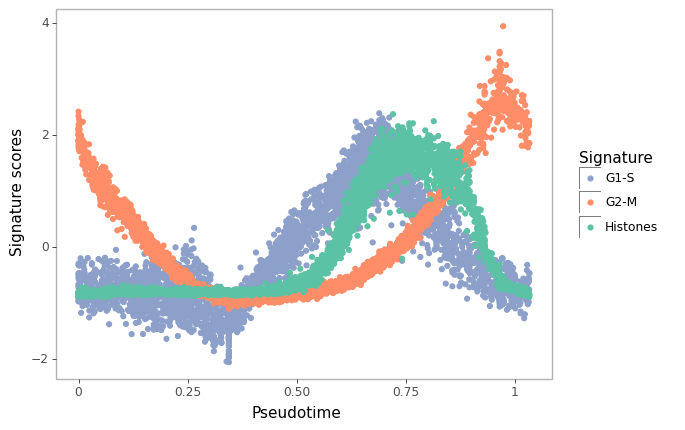

<ggplot: (8771579925152)>

In [18]:
cc.pl.cell_cycle_scores(chla9)

`tl.cell_cycle_phase` uses the curvature of the trajectory to find inflection points in the expression of genes that define the cell cycle and set boundaries between cell cycle phases. It set the boundaries at the points in the trajectory where the curvature is the highest. 

-- Suggested cell cycle division:
G1:  0   - 0.3333333333333333
S:  0.3333333333333333 - 0.6
G2-M: 0.6 - 1


/home/clarice/.local/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning:

geom_vline : Removed 1 rows containing missing values.



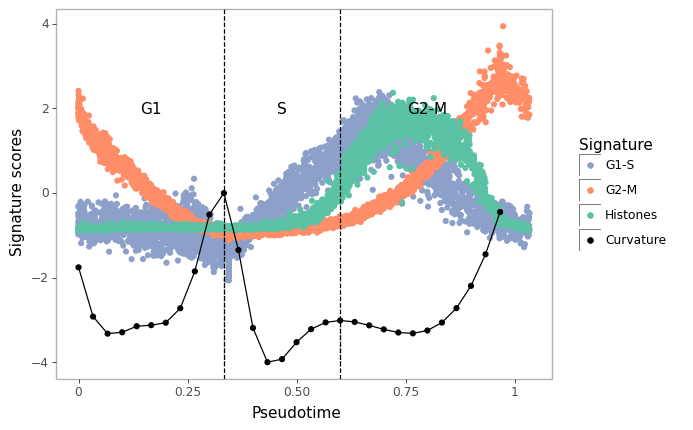

<ggplot: (8771579921291)>

In [19]:
cc.tl.cell_cycle_phase(chla9)
cc.pl.cell_cycle_scores(chla9)

We can check how the cells were assigned into cell cycle phase 'categories' by looking at the pieplot:

([<matplotlib.patches.Wedge at 0x7fa4af3765b0>,
 [Text(0.2347406999840586, 1.1257871929325693, 'G2-M'),
  Text(-1.0795622065250772, -0.3962895939117084, 'S'),
  Text(0.6083086413515486, -0.9759408777467175, 'G1')],
 [Text(0.11226729129672366, 0.5384199618373158, '43.5%'),
  Text(-0.5163123596424282, -0.18952980578386053, '24.3%'),
  Text(0.2909302197768276, -0.46675433283538653, '32.3%')])

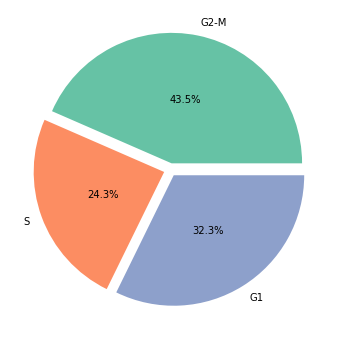

In [20]:
cc.pl.cell_cycle_phase_pieplot(chla9)

or plotting using our friend `pl.cell_cycle_pca` setting `col_var = 'cell_cycle_phase'`:

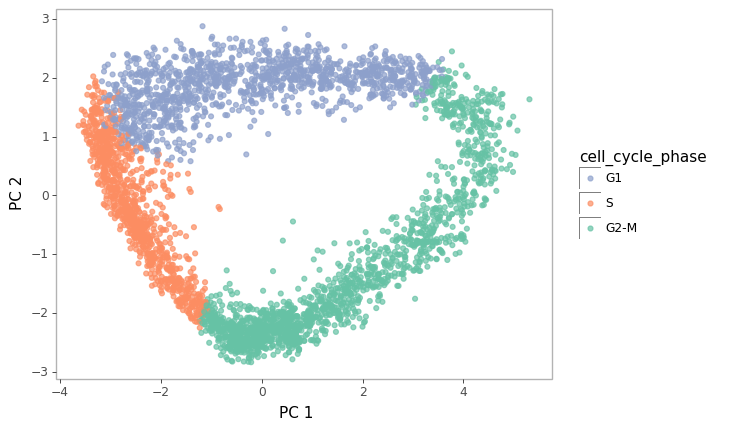

<ggplot: (8771552735561)>

In [23]:
from plotnine import scale_color_manual
(cc.pl.cell_cycle_pca(chla9, 'cell_cycle_phase') 
 + scale_color_manual(values = ['#8da0cb', '#fc8d62', '#66c2a5']))

## Cell cycle and RNA velocity

As `scycle` is built on top of AnnData, it is compatible with many other Python libraries that are built on the same platform, such as `scanpy` and `scvelo`. Since our example was loaded from a `loom` file, we have access to the unspliced and spliced matrices, and can look at RNA velocity in the cell cycle space

In [25]:
import scvelo as sv
sv.pp.moments(chla9)
sv.tl.velocity(chla9)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [26]:
sv.tl.velocity_graph(chla9)

computing velocity graph (using 1/12 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_dimRed', embedded velocity vectors (adata.obsm)


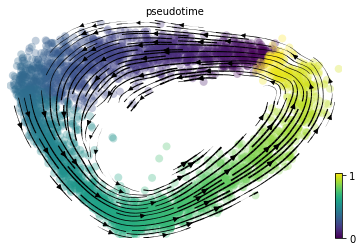

In [27]:
sv.pl.velocity_embedding_stream(chla9, basis = 'X_dimRed', color = 'pseudotime')

We can see in the stream plot a clear, orthogonal confirmation of inferred pseudotime directionality through RNA velocity.